DeepLarning Couse HSE 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```,
* ```https://vk.com/ars.ashuha``` 
* partially reusing https://github.com/ebenolson/pydata2015

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [2]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-04-02 06:40:30--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/88i82bqecFPGkLfuw4YDpvsSIbHuPK3KMKSORo6WbYdhcptn86KJmTrKuLtk2W36/file?dl=1 [following]
--2017-04-02 06:40:31--  https://dl.dropboxusercontent.com/content_link/88i82bqecFPGkLfuw4YDpvsSIbHuPK3KMKSORo6WbYdhcptn86KJmTrKuLtk2W36/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

100%[======================================>] 506,221,998  754KB/s   in 12m 7s 

2017-04-02 06:52:40 (680 KB/s) - ‘data.tar.gz’ sa

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.13 s, sys: 164 ms, total: 2.29 s
Wall time: 2.32 s


In [3]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)

In [6]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

#good old as_matrix for the third time
def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [9]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 256  #128 #pls change me if u want
LSTM_UNITS = 400  #200 #pls change me if u want

In [10]:
import theano
import theano.tensor as T

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [11]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences,PAD_ix)

In [12]:
import lasagne
from lasagne.layers import *

In [13]:
#network inputs
l_words = InputLayer((None,None),sentences )
l_mask = InputLayer((None,None),sentence_mask)

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words,n_tokens,EMBED_SIZE)

#cudos for using some pre-trained embedding :)

In [14]:
# input layer for image features
l_image_features = InputLayer((None,CNN_FEATURE_SIZE),image_vectors)

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None,LSTM_UNITS)

In [15]:
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5)

#find out better recurrent architectures for bonus point

In [16]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

broadcasted decoder shape =  (None, 400)


In [17]:
#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks,n_tokens,
                                               nonlinearity=lasagne.nonlinearities.softmax)
# maybe a more complicated architecture will work better?

In [18]:
#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print "output shape = ",predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

output shape =  (None, None, 10373)


### Some tricks
* If you train large network, it is usually a good idea to make a 2-stage prediction
    1. (large recurrent state) -> (bottleneck e.g. 256)
    2. (bottleneck) -> (vocabulary size)
    * this way you won't need to store/train (large_recurrent_state x vocabulary size) matrix
* Also maybe use Hierarchical Softmax?
    * https://gist.github.com/justheuristic/581853c6d6b87eae9669297c2fb1052d




In [19]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:,:-1].reshape((-1,n_tokens)),
    reference_answers.reshape((-1,))).reshape(reference_answers.shape)

#mean over non-PAD tokens
loss = (loss*output_mask).sum() / output_mask.sum()

In [20]:
#trainable NN weights
weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss,weights)

In [21]:
%%time

#compile a functions for training and evaluation
#please not that your functions must accept image features as FIRST param and sentences as second one
train_step = theano.function([image_vectors,sentences],loss,updates=updates)
val_step   = theano.function([image_vectors,sentences],loss)
#for val_step use deterministic=True if you have any dropout/noize

CPU times: user 49.2 s, sys: 196 ms, total: 49.4 s
Wall time: 50.5 s


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [22]:
captions = np.array(captions)

In [23]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0,len(images),size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice,captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [24]:
generate_batch(img_codes,captions,3)

(array([[-3.14702606, -4.61250734, -3.31662369, ..., -0.11247337,
          0.83743781,  7.37500763],
        [-2.13610077, -5.64171696,  1.24350774, ..., -2.39718509,
         -0.26781476, -3.1048727 ],
        [-4.15734053,  3.51650572, -3.62838364, ...,  2.10626006,
          5.99871349,  6.19900227]], dtype=float32),
 array([[8481, 8717, 5627, 7064, 4888, 8528, 8717, 8534, 2802, 9609, 9752,
         5448, 7828,    0, 8134],
        [8481, 5164, 2215, 3069,  535, 5470, 7115, 5155,  781, 8717, 3601,
         4212, 8134,   -1,   -1],
        [8481, 8717, 8897, 9049, 8774, 8800, 8717, 9001, 4859, 5824, 8134,
           -1,   -1,   -1,   -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [25]:
batch_size=100 #50 #adjust me
n_epochs=100 #adjust me
n_batches_per_epoch = 100 #50 #adjust me
n_validation_batches = 10 #5 #how many batches are used for validation after each epoch

In [26]:
%%time

from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  1%|          | 1/100 [00:00<00:15,  6.60it/s]

Epoch: 0, train loss: 5.63039413929, val loss: 4.78566784859


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, train loss: 4.39245811462, val loss: 4.07523269653


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, train loss: 3.89758490086, val loss: 3.77702765465


  1%|          | 1/100 [00:00<00:18,  5.28it/s]

Epoch: 3, train loss: 3.65647702932, val loss: 3.59509401321


  1%|          | 1/100 [00:00<00:15,  6.59it/s]

Epoch: 4, train loss: 3.53467267036, val loss: 3.44788095951


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

Epoch: 5, train loss: 3.39301060677, val loss: 3.35118088722


  1%|          | 1/100 [00:00<00:19,  5.16it/s]

Epoch: 6, train loss: 3.30892601013, val loss: 3.25920026302


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, train loss: 3.24079305172, val loss: 3.15397098064


  1%|          | 1/100 [00:00<00:19,  5.10it/s]

Epoch: 8, train loss: 3.1849354291, val loss: 3.1692019701


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, train loss: 3.13720505476, val loss: 3.10289466381


  1%|          | 1/100 [00:00<00:19,  5.15it/s]

Epoch: 10, train loss: 3.08648608923, val loss: 3.07445430756


  1%|          | 1/100 [00:00<00:15,  6.25it/s]

Epoch: 11, train loss: 3.0488801527, val loss: 2.9812984705


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, train loss: 3.01415914297, val loss: 3.03553860188


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13, train loss: 2.9826961112, val loss: 2.94884779453


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

Epoch: 14, train loss: 2.95483245134, val loss: 2.87311022282


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

Epoch: 15, train loss: 2.92692158461, val loss: 2.96308906078


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16, train loss: 2.9062119031, val loss: 2.90931456089


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17, train loss: 2.86690632582, val loss: 2.82188134193


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18, train loss: 2.87484695911, val loss: 2.86041083336


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19, train loss: 2.86176357269, val loss: 2.79328453541


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20, train loss: 2.83041840792, val loss: 2.82883355618


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21, train loss: 2.80962446451, val loss: 2.84275896549


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

Epoch: 22, train loss: 2.8072737956, val loss: 2.77142345905


  1%|          | 1/100 [00:00<00:14,  6.61it/s]

Epoch: 23, train loss: 2.78294118404, val loss: 2.77418243885


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24, train loss: 2.78188936472, val loss: 2.79698419571


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25, train loss: 2.75988993168, val loss: 2.75768489838


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26, train loss: 2.74611867905, val loss: 2.7578930378


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27, train loss: 2.75041191339, val loss: 2.71619508266


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28, train loss: 2.71433211803, val loss: 2.73857345581


  1%|          | 1/100 [00:00<00:15,  6.25it/s]

Epoch: 29, train loss: 2.71884433746, val loss: 2.71265070438


  1%|          | 1/100 [00:00<00:19,  5.04it/s]

Epoch: 30, train loss: 2.68583261013, val loss: 2.70444347858


  1%|          | 1/100 [00:00<00:15,  6.24it/s]

Epoch: 31, train loss: 2.69344819307, val loss: 2.66994957924


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

Epoch: 32, train loss: 2.69539022446, val loss: 2.69030950069


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 33, train loss: 2.67042571783, val loss: 2.69162042141


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 34, train loss: 2.66031388521, val loss: 2.67919051647


  1%|          | 1/100 [00:00<00:18,  5.37it/s]

Epoch: 35, train loss: 2.67269340992, val loss: 2.67094187737


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 36, train loss: 2.6589941597, val loss: 2.64597148895


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 37, train loss: 2.6451559639, val loss: 2.62863311768


  1%|          | 1/100 [00:00<00:19,  5.15it/s]

Epoch: 38, train loss: 2.64276971817, val loss: 2.65266692638


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 39, train loss: 2.63931306362, val loss: 2.6097058773


  1%|          | 1/100 [00:00<00:18,  5.38it/s]

Epoch: 40, train loss: 2.63083397865, val loss: 2.58437800407


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

Epoch: 41, train loss: 2.62002961397, val loss: 2.61474392414


  1%|          | 1/100 [00:00<00:18,  5.37it/s]

Epoch: 42, train loss: 2.59432816744, val loss: 2.58170464039


  1%|          | 1/100 [00:00<00:19,  5.08it/s]

Epoch: 43, train loss: 2.61139284849, val loss: 2.62315638065


  1%|          | 1/100 [00:00<00:18,  5.26it/s]

Epoch: 44, train loss: 2.59840693712, val loss: 2.61148021221


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 45, train loss: 2.60254010916, val loss: 2.60749034882


  1%|          | 1/100 [00:00<00:18,  5.39it/s]

Epoch: 46, train loss: 2.60505166769, val loss: 2.57684674263


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

Epoch: 47, train loss: 2.57279697895, val loss: 2.55675468445


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 48, train loss: 2.57179536819, val loss: 2.56492991447


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 49, train loss: 2.57302383661, val loss: 2.57842423916


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 50, train loss: 2.5795065093, val loss: 2.52690999508


  1%|          | 1/100 [00:00<00:18,  5.36it/s]

Epoch: 51, train loss: 2.55366116047, val loss: 2.52347342968


  1%|          | 1/100 [00:00<00:19,  5.05it/s]

Epoch: 52, train loss: 2.55003876686, val loss: 2.58347547054


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 53, train loss: 2.55400106192, val loss: 2.54002764225


  1%|          | 1/100 [00:00<00:16,  6.10it/s]

Epoch: 54, train loss: 2.55415855408, val loss: 2.47784926891


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 55, train loss: 2.55412148237, val loss: 2.57307062149


  1%|          | 1/100 [00:00<00:18,  5.30it/s]

Epoch: 56, train loss: 2.53810792208, val loss: 2.53790268898


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

Epoch: 57, train loss: 2.5270364666, val loss: 2.50932161808


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

Epoch: 58, train loss: 2.52877334118, val loss: 2.52201242447


  1%|          | 1/100 [00:00<00:18,  5.29it/s]

Epoch: 59, train loss: 2.53550323248, val loss: 2.53437366486


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

Epoch: 60, train loss: 2.52888227701, val loss: 2.50595543385


  1%|          | 1/100 [00:00<00:16,  5.85it/s]

Epoch: 61, train loss: 2.5146362257, val loss: 2.51797029972


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 62, train loss: 2.4956580472, val loss: 2.42594192028


  1%|          | 1/100 [00:00<00:19,  5.03it/s]

Epoch: 63, train loss: 2.51494177341, val loss: 2.54730465412


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

Epoch: 64, train loss: 2.4999531889, val loss: 2.52363734245


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

Epoch: 65, train loss: 2.51203596115, val loss: 2.55160117149


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 66, train loss: 2.48186436415, val loss: 2.46442496777


  1%|          | 1/100 [00:00<00:19,  5.06it/s]

Epoch: 67, train loss: 2.49842300653, val loss: 2.49400882721


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

Epoch: 68, train loss: 2.50742835045, val loss: 2.43819115162


  1%|          | 1/100 [00:00<00:18,  5.27it/s]

Epoch: 69, train loss: 2.48016386271, val loss: 2.55821387768


  1%|          | 1/100 [00:00<00:19,  5.12it/s]

Epoch: 70, train loss: 2.48164270639, val loss: 2.48044660091


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

Epoch: 71, train loss: 2.47936410427, val loss: 2.51034002304


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

Epoch: 72, train loss: 2.47860030651, val loss: 2.48570609093


  1%|          | 1/100 [00:00<00:15,  6.30it/s]

Epoch: 73, train loss: 2.45927286148, val loss: 2.41886606216


  1%|          | 1/100 [00:00<00:14,  6.62it/s]

Epoch: 74, train loss: 2.48236277342, val loss: 2.49418408871


  1%|          | 1/100 [00:00<00:19,  5.08it/s]

Epoch: 75, train loss: 2.472751019, val loss: 2.49250617027


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

Epoch: 76, train loss: 2.47115045786, val loss: 2.50915312767


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 77, train loss: 2.45949067354, val loss: 2.46276555061


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

Epoch: 78, train loss: 2.44906362295, val loss: 2.41598308086


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

Epoch: 79, train loss: 2.45215215921, val loss: 2.47434813976


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 80, train loss: 2.45611322403, val loss: 2.39819180965


  1%|          | 1/100 [00:00<00:15,  6.26it/s]

Epoch: 81, train loss: 2.46237458467, val loss: 2.40245044231


  1%|          | 1/100 [00:00<00:18,  5.40it/s]

Epoch: 82, train loss: 2.43248328686, val loss: 2.39790849686


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 83, train loss: 2.44308176279, val loss: 2.43083500862


  1%|          | 1/100 [00:00<00:19,  5.16it/s]

Epoch: 84, train loss: 2.45878550291, val loss: 2.46405308247


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 85, train loss: 2.43963918924, val loss: 2.47700779438


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

Epoch: 86, train loss: 2.42974404573, val loss: 2.41350181103


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 87, train loss: 2.43043092966, val loss: 2.4165396452


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 88, train loss: 2.42458591938, val loss: 2.40363533497


  1%|          | 1/100 [00:00<00:18,  5.40it/s]

Epoch: 89, train loss: 2.43958050489, val loss: 2.42970278263


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 90, train loss: 2.42173845768, val loss: 2.45822279453


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 91, train loss: 2.41664643526, val loss: 2.43997819424


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 92, train loss: 2.43616929054, val loss: 2.43397734165


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 93, train loss: 2.42299319744, val loss: 2.41820552349


  1%|          | 1/100 [00:00<00:16,  5.98it/s]

Epoch: 94, train loss: 2.43156569958, val loss: 2.38929791451


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 95, train loss: 2.41985047102, val loss: 2.49031770229


  1%|          | 1/100 [00:00<00:19,  5.16it/s]

Epoch: 96, train loss: 2.41388328075, val loss: 2.39023058414


  1%|          | 1/100 [00:00<00:19,  5.16it/s]

Epoch: 97, train loss: 2.41168502808, val loss: 2.3632270813


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 98, train loss: 2.41263367891, val loss: 2.43065330982


100%|██████████| 100/100 [00:22<00:00,  4.97it/s]


Epoch: 99, train loss: 2.41702648878, val loss: 2.45302977562
Finish :)
CPU times: user 32min 25s, sys: 5min 42s, total: 38min 8s
Wall time: 38min 21s


In [27]:
123

123

### apply trained model

In [28]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

## Generate caption

In [29]:
last_word_probas = get_output(predicted_probabilities,deterministic=True)[:,-1]
#TRY OUT deterministic=True if you want more steady results

get_probs = theano.function([image_vectors,sentences], last_word_probas)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption])).ravel()
        assert len(next_word_probs.shape) ==1 #must be one-dimensional
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline

### Good examples

/home/user/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


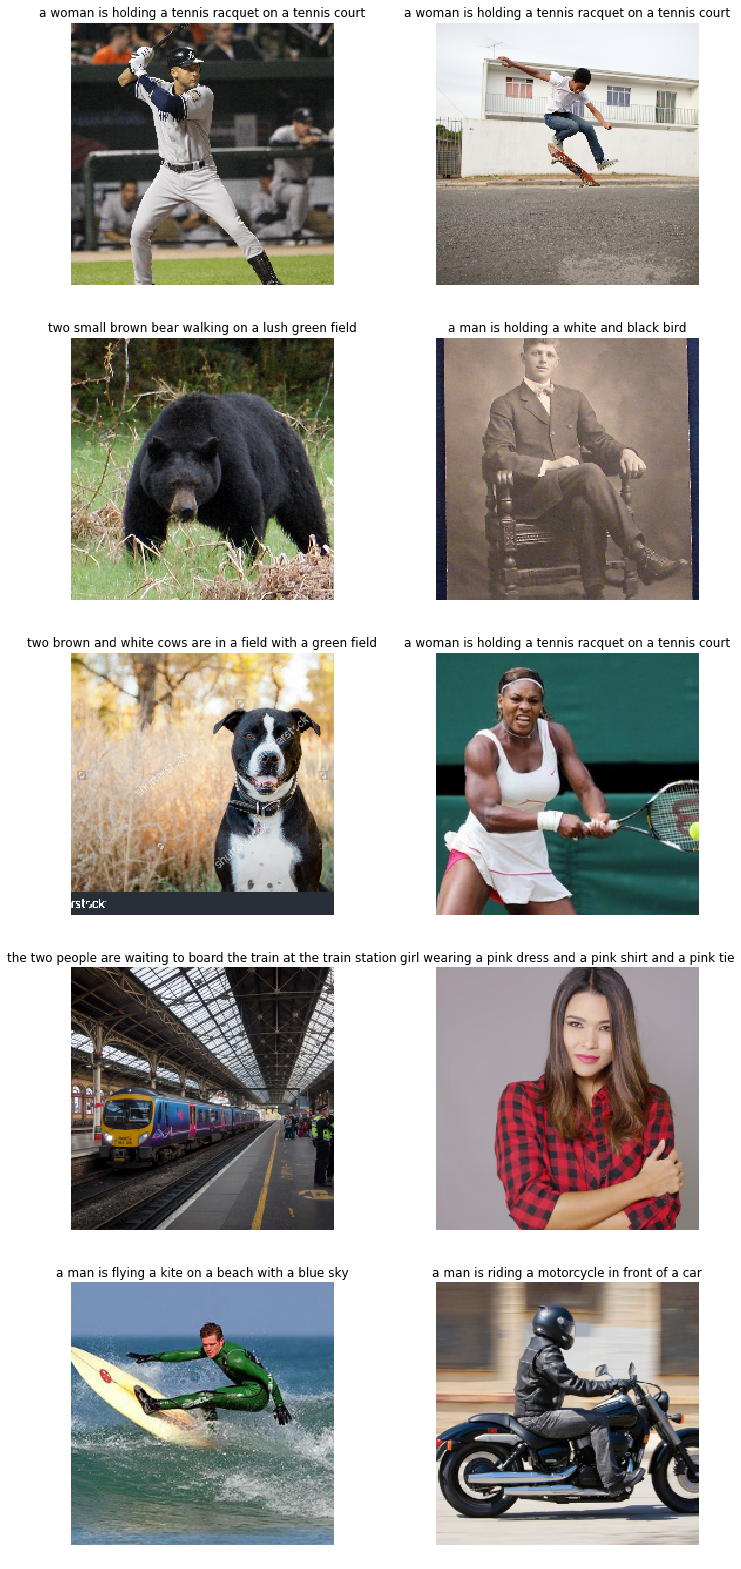

In [31]:

plt.figure(figsize=(12,28))
for i in range(10):
    img = plt.imread('good/img'+str(i+1)+'.jpg')
    img = preprocess(img)
    txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
    plt.subplot(5,2,i+1)
    plt.axis('off')
    plt.title(txt)
    plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
    

### Fail examples

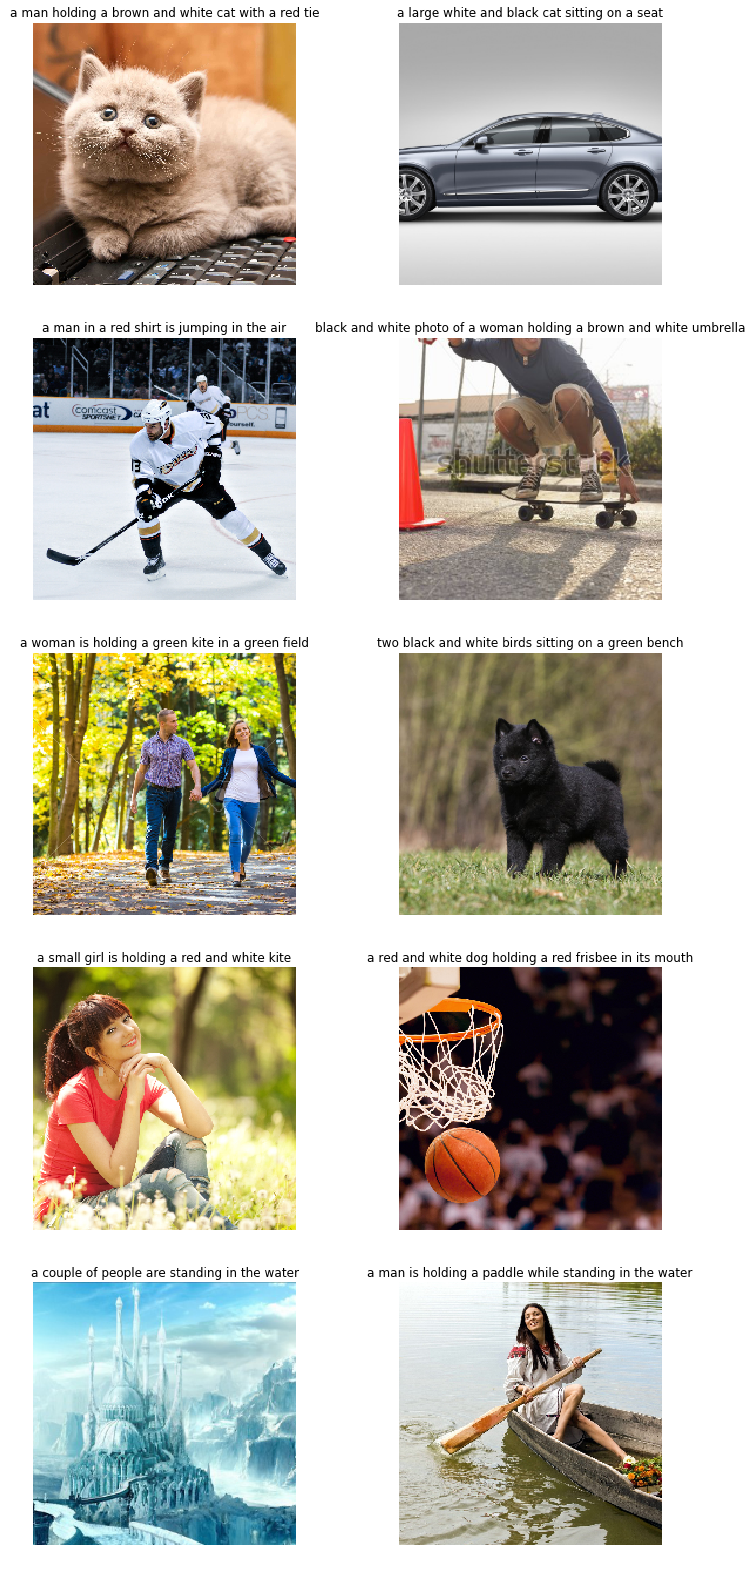

In [32]:
plt.figure(figsize=(12,28))
for i in range(10):
    img = plt.imread('fail/img'+str(i+1)+'.jpg')
    img = preprocess(img)
    txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
    plt.subplot(5,2,i+1)
    plt.axis('off')
    plt.title(txt)
    plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

# grading

* base 5 if it compiles and trains without exploding
* +1 for finding representative set of reference examples
* +2 for providing 10+ examples where network provides reasonable captions (at least sometimes :) )
  * you may want to predict with sample=False and deterministic=True for consistent results
  * kudos for submitting network params that reproduce it
* +2 for providing 10+ examples where network fails IF you also got previous 10 examples right


* bonus points for experiments with architecture and initialization (see above)
* bonus points for trying out other pre-trained nets for captioning
* a whole lot of bonus points if you also train via metric learning
 * image -> vec
 * caption -> vec (encoder, not decoder)
 * loss = correct captions must be closer, wrong ones must be farther
 * prediction = choose caption that is closest to image
* a freaking whole lot of points if you also obtain statistically signifficant results the other way round
 * take caption, get closest image